In [3]:
from time import time
import pandas as pd
import numpy as np
from gensim.models import KeyedVectors
import re
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
# import seaborn as sns

import itertools
import datetime

from keras.preprocessing.sequence import pad_sequences
from keras.models import Model
from keras.layers import Input, Embedding, LSTM, Merge, Lambda
import keras.backend as K
from keras.optimizers import Adadelta
from keras.callbacks import ModelCheckpoint

Using TensorFlow backend.
/Users/tomek/anaconda3/envs/eng/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


# Data preprocessing

## Load data from prepared .csv files

In [4]:
EMBEDDING_FILE = '/Volumes/DataDrive/models/GoogleNews-vectors-negative300.bin'
# TRAIN_CSV = '/Volumes/DataDrive/stripped/english-train.csv'
# TEST_CSV = '/Volumes/DataDrive/stripped/english-devel.csv'

TRAIN_CSV = '/Volumes/DataDrive/stripped/english-train-xsmall.csv'
TEST_CSV = '/Volumes/DataDrive/stripped/english-devel-xsmall.csv'

In [5]:
# Load training and test set
train_df = pd.read_csv(TRAIN_CSV)
test_df = pd.read_csv(TEST_CSV)

stops = set(stopwords.words('english'))

def text_to_word_list(text):
    ''' Pre process and convert texts to a list of words '''
    text = str(text)
    text = text.lower()

    # Clean the text
    text = re.sub(r"[^A-Za-z0-9^,!.\/'+-=]", " ", text)
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "cannot ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r",", " ", text)
    text = re.sub(r"\.", " ", text)
    text = re.sub(r"!", " ! ", text)
    text = re.sub(r"\/", " ", text)
    text = re.sub(r"\^", " ^ ", text)
    text = re.sub(r"\+", " + ", text)
    text = re.sub(r"\-", " - ", text)
    text = re.sub(r"\=", " = ", text)
    text = re.sub(r"'", " ", text)
    text = re.sub(r"(\d+)(k)", r"\g<1>000", text)
    text = re.sub(r":", " : ", text)
    text = re.sub(r" e g ", " eg ", text)
    text = re.sub(r" b g ", " bg ", text)
    text = re.sub(r" u s ", " american ", text)
    text = re.sub(r"\0s", "0", text)
    text = re.sub(r" 9 11 ", "911", text)
    text = re.sub(r"e - mail", "email", text)
    text = re.sub(r"j k", "jk", text)
    text = re.sub(r"\s{2,}", " ", text)

    text = text.split()

    return text

# Prepare embedding
vocabulary = dict()
inverse_vocabulary = ['<unk>']  # '<unk>' will never be used, it is only a placeholder for the [0, 0, ....0] embedding

print("Loading word2vec model...")
word2vec = KeyedVectors.load_word2vec_format(EMBEDDING_FILE, binary=True)
print("Done.")

questions_cols = ['original_question_text', 'related_question_text']

print("Building vocabulary...")
# Iterate over the questions only of both training and test datasets
for dataset in [train_df, test_df]:
    for index, row in dataset.iterrows():

        # Iterate through the text of both questions of the row
        for question in questions_cols:

            q2n = []  # q2n -> question numbers representation
            for word in text_to_word_list(row[question]):

                # Check for unwanted words
                if word in stops and word not in word2vec.vocab:
                    continue

                if word not in vocabulary:
                    vocabulary[word] = len(inverse_vocabulary)
                    q2n.append(len(inverse_vocabulary))
                    inverse_vocabulary.append(word)
                else:
                    q2n.append(vocabulary[word])

            # Replace questions as word to question as number representation
            dataset.set_value(index, question, q2n)
            
print("Done.")
            
embedding_dim = 300
embeddings = 1 * np.random.randn(len(vocabulary) + 1, embedding_dim)  # This will be the embedding matrix
embeddings[0] = 0  # So that the padding will be ignored

print("Building embedding matrix...")
# Build the embedding matrix
for word, index in vocabulary.items():
    if word in word2vec.vocab:
        embeddings[index] = word2vec.word_vec(word)

del word2vec
print("Done.")

Loading word2vec model...
Done.
Building vocabulary...


/Users/tomek/anaconda3/envs/eng/lib/python3.6/site-packages/ipykernel/__main__.py:80: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead


Done.
Building embedding matrix...
Done.


## Split dataset into train-dev-test sets

In [46]:
max_seq_length = max(train_df.original_question_text.map(lambda x: len(x)).max(),
                     train_df.related_question_text.map(lambda x: len(x)).max(),
                     test_df.original_question_text.map(lambda x: len(x)).max(),
                     test_df.related_question_text.map(lambda x: len(x)).max())

print("Max sequence length = {}".format(max_seq_length))

# Split to train validation
validation_size = 100
training_size = len(train_df) - validation_size

X = train_df[questions_cols]

Y = train_df['relevance']
print(Y.head(n=2))

Y = Y.map(lambda x: '1' if x == 'PerfectMatch' else 0)
print(Y.head(n=2))

X_train, X_validation, Y_train, Y_validation = train_test_split(X, Y, test_size=validation_size)
Y_test = test_df['relevance'].map(lambda x: 1 if x == 'PerfectMatch' else 0)

# Split to dicts
X_train = {'left': X_train.original_question_text, 'right': X_train.related_question_text}
X_validation = {'left': X_validation.original_question_text, 'right': X_validation.related_question_text}
X_test = {'left': test_df.original_question_text, 'right': test_df.related_question_text}

# Convert labels to their numpy representations
Y_train = Y_train.values
Y_validation = Y_validation.values

# Zero padding
for dataset, side in itertools.product([X_train, X_validation, X_test], ['left', 'right']):
    dataset[side] = pad_sequences(dataset[side], maxlen=max_seq_length)

# Make sure everything is ok
assert X_train['left'].shape == X_train['right'].shape
assert len(X_train['left']) == len(Y_train)

Max sequence length = 910
0      [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 7, 8, 12, ...
1      [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 7, 8, 12, ...
2      [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 7, 8, 12, ...
3      [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 7, 8, 12, ...
4      [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 7, 8, 12, ...
5      [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 7, 8, 12, ...
6      [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 7, 8, 12, ...
7      [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 7, 8, 12, ...
8      [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 7, 8, 12, ...
9      [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 7, 8, 12, ...
10     [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 7, 8, 12, ...
11     [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 7, 8, 12, ...
12     [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 7, 8, 12, ...
13     [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 7, 8, 12, ...
14     [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 7, 8, 12, ...
15     [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 7, 8, 12, ...
16     [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 7, 8, 12, ...
17   

# Model

In [9]:
n_hidden = 50
gradient_clipping_norm = 1.25
batch_size = 64
n_epoch = 20


def _my_out_shape(shapes):
    return (shapes[0][0], 1);

def _exponent_neg_manhattan_distance(lay):
    '''Overriden exponent manhattan distance function'''
    return K.exp(-K.sum(K.abs(lay[0]-lay[1]), axis=1, keepdims=True))

def exponent_neg_manhattan_distance(left, right):
    ''' Helper function for the similarity estimate of the LSTMs outputs'''
    return K.exp(-K.sum(K.abs(left-right), axis=1, keepdims=True))

# The visible layer
left_input = Input(shape=(max_seq_length,), dtype='int32')
right_input = Input(shape=(max_seq_length,), dtype='int32')

embedding_layer = Embedding(len(embeddings), embedding_dim, weights=[embeddings], input_length=max_seq_length, trainable=False)

# Embedded version of the inputs
encoded_left = embedding_layer(left_input)
encoded_right = embedding_layer(right_input)

# Since this is a siamese network, both sides share the same LSTM
shared_lstm = LSTM(n_hidden)

left_output = shared_lstm(encoded_left)
right_output = shared_lstm(encoded_right)

malstm_distance = Lambda(_exponent_neg_manhattan_distance, output_shape=_my_out_shape)([left_output, right_output])
# Calculates the distance as defined by the MaLSTM model
# malstm_distance = Merge(mode=lambda x: exponent_neg_manhattan_distance(x[0], x[1]), output_shape=lambda x: (x[0][0], 1))([left_output, right_output])

# Pack it all up into a model
malstm = Model([left_input, right_input], [malstm_distance])

# Adadelta optimizer, with gradient clipping by norm
optimizer = Adadelta(clipnorm=gradient_clipping_norm)

malstm.compile(loss='mean_squared_error', optimizer=optimizer, metrics=['accuracy'])

# Training

In [10]:
# Start training
training_start_time = time()

malstm_trained = malstm.fit([X_train['left'], X_train['right']], Y_train, batch_size=batch_size, epochs=10,
                            validation_data=([X_validation['left'], X_validation['right']], Y_validation))

print("Training time finished.\n{} epochs in {}".format(n_epoch, datetime.timedelta(seconds=time()-training_start_time)))

Train on 500 samples, validate on 100 samples
Epoch 1/10
500/500 [==============================] - 24s 49ms/step - loss: 0.0062 - acc: 0.9960 - val_loss: 0.0023 - val_acc: 1.0000
Epoch 2/10
500/500 [==============================] - 24s 49ms/step - loss: 0.0057 - acc: 0.9960 - val_loss: 0.0020 - val_acc: 1.0000
Epoch 3/10
500/500 [==============================] - 23s 46ms/step - loss: 0.0054 - acc: 0.9960 - val_loss: 0.0018 - val_acc: 1.0000
Epoch 4/10
500/500 [==============================] - 23s 46ms/step - loss: 0.0050 - acc: 0.9960 - val_loss: 0.0017 - val_acc: 1.0000
Epoch 5/10
500/500 [==============================] - 24s 48ms/step - loss: 0.0048 - acc: 0.9960 - val_loss: 0.0016 - val_acc: 1.0000
Epoch 6/10
500/500 [==============================] - 22s 45ms/step - loss: 0.0045 - acc: 0.9960 - val_loss: 0.0015 - val_acc: 1.0000
Epoch 7/10
500/500 [==============================] - 23s 46ms/step - loss: 0.0043 - acc: 0.9960 - val_loss: 0.0014 - val_acc: 1.0000
Epoch 8/10
500/5

# Data vis

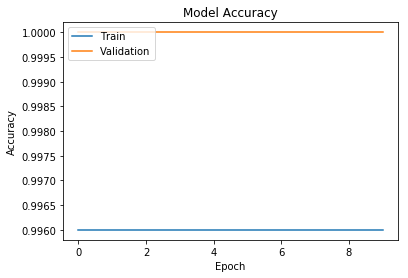

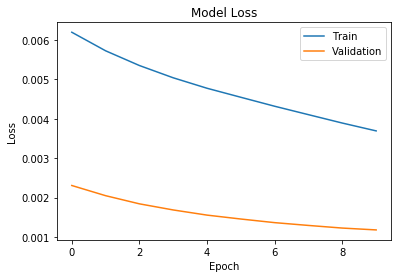

In [12]:
# Plot accuracy
plt.plot(malstm_trained.history['acc'])
plt.plot(malstm_trained.history['val_acc'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot loss
plt.plot(malstm_trained.history['loss'])
plt.plot(malstm_trained.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

In [35]:
test_input = [X_test['left'], X_test['right']]
malstm.evaluate(test_input, Y_test)

250/250 [==============================] - 4s 15ms/step


[0.0033510473184287549, 1.0]

In [24]:
print(X_test['left'].shape)
print(X_test['right'].shape)
print(Y_test.shape)

(250,)
(250,)
(250,)


In [36]:
word2vec = KeyedVectors.load_word2vec_format(EMBEDDING_FILE, binary=True)

In [101]:
def parse_sentence(sentence, vec_len=max_seq_length):
    word_list = text_to_word_list(sentence)
    q2n = []
    for word in word_list:
        # Check for unwanted words
        if word in stops or word not in vocabulary:
            continue

        q2n.append(vocabulary[word])

    padded = pad_sequences([q2n], maxlen=vec_len)[0]
    return padded
    
    
def predict(model, left_sentence, right_sentence, threshold=0.4, binary=False):
    left_vec = parse_sentence(left_sentence)
    right_vec = parse_sentence(right_sentence)

    model_input = [np.array([left_vec]), np.array([right_vec])]
    prediction = model.predict(model_input)[0][0]
    
    if binary:
        return prediction > threshold
    
    return prediction

In [107]:
left_sentence = "I believe that to infinitive as a subject can be replaced by a gerund form, which is why     To get up early is good.   always has the same meaning as     Getting up early is good.   But a colleague of mine tells me this isn't always the case. I did not have a chance to have him elaborate on that. He cited the following sentence:     Neglecting others means ignoring    and only said that because of 'ignoring', you cannot use 'to neglect' instead of 'neglecting'.   Is he right If so, why"
right_sentence = "Is it correct to say \"Would you mind to do something\". I've seen this usage in a few places, but it doesn't sound right to me. I would guess that it's proper to use \"Would you mind doing something\" instead.  Yet there are other verbs we could substitute here that make it sound correct with \"to\". For example, \"Would you like to do something\" and \"Would you care to do something\" Could someone explain why \"mind to\" doesn't sound correct in this context, while \"like to\" and \"care to\" sound exactly right"

predict(malstm, left_sentence, right_sentence)

0.077183016